
# Building an Image and Text Vector Database with FAISS and CLIP

This notebook aims to create a vector database for images using Facebook's FAISS (Facebook AI Similarity Search). I chose FAISS because it's easy to set up and open-source. It works well for finding similarities and organizing dense vectors, which is great for handling large datasets like images or text embeddings. In this case, I'm using images and converting them into embedded vectors.

The plan is to turn the images into dense vectors of a specific size and store them in a vector index. For a more complete vector database, ChromaDB would be a better choice. We have two options for using images with a vector database: we can store the embedded vectors and then search using a new image to find similar ones. We can specify a parameter k
to get the top K closest images. I’m using the Flickr8 dataset, which contains about 8,000 images, each with five captions.

Instead of just searching for images, I thought it would be better to also include text. This way, we can use natural language descriptions to find matching images.

One way to do this is by using two different embedding methods for images and text. For example, we could use a ResNet model for images, but since ResNet is built on CNN architecture and only works with images, we also need a different model, like BERT a transformer architecture, to embed the text. This presents some challenges, such as aligning the image and text embeddings in the same space and ensuring their dimensions match.

OpenAI's CLIP (Contrastive Language–Image Pre-training) model can embed both images and text into a shared space, allowing it to understand both types of content together. This enables tasks like image searches, classification without specific training, and image recognition based on text descriptions. CLIP's approach allows for flexible searches across images and text, which can be useful for answering visual questions or improving recommendations.

**CLIP Approach **

<div style="text-align: center;">
    <img src="https://images.ctfassets.net/kftzwdyauwt9/fbc4f633-9ad4-4dc2-3809c22df5e0/0bd2d5abf90d052731538613e4a42668/overview-a.svg" alt="Overview of CLIP" width="400"/>      
</div>

### Reference
- image from https://openai.com/index/clip/

- Flickr8 dataset downloaded from Kaggle https://www.kaggle.com/datasets/adityajn105/flickr8k

To train the model with the Flickr8 dataset, I’m using Google Colab with GPU support, and can use a CPU for inference provided we save the model and tokenizer and use that. Training takes about 15-20 minutes on a GPU.

In [1]:
#mounting goggle drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#installed from command prompt
#conda create -n proj_env python=3.9
#conda activate proj_env
#pip install tensorflow==2.10.0 transformers==4.44.2 faiss-cpu pandas pillow tokenizers==0.19.0 safetensors

In [2]:
!pip install faiss-cpu
!pip install faiss-gpu
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
from PIL import Image
import os
from transformers import CLIPProcessor, TFCLIPModel, CLIPTokenizer
import tensorflow as tf
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import faiss
import numpy as np
from collections import defaultdict
import json
import warnings

warnings.filterwarnings("ignore")


In [4]:
# Check available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Using GPU: {gpus}")
else:
    print("Using CPU")

Using CPU


The file should be in teh following hierarchy,

train_flickr8_dataset/
  - Images/
  - captions.txt

Image Vector EmbeddingV2.ipynb

In [5]:
#path to flickr8 dataset
dataset_path = "/content/drive/MyDrive/VectorDB/train_flickr8_dataset"
captions_df = pd.read_csv(os.path.join(dataset_path, "captions.txt"))

#captions_df = captions_df.head(10) #temp to test it out before running full dataset
captions_df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


To create embeddings in teh below code, we utilize the Hugging Face Transformers library to load the CLIP variant titled vit-base-patch32. First, we load this pre-trained model from OpenAI. Next, we use a processor to preprocess both the image and the text. Finally, we employ a tokenizer to convert the text into tokens, which will be used for embedding.

In [6]:
# Load CLIP model, processor and tokenizer
model = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/606M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In the method below, we are embedding captions for each image. However, since each image has five distinct captions, directly embedding them would result in five separate embeddings for each image, leading to taking more storage space in FAISS.

To handle this, we can embed each caption after tokenizing the text, then map each embedding to the image once, avoiding repeated image paths. This approach provides five unique embeddings per image (one per caption), which can be stored in the vector index alongside each image. While this setup requires more storage, it maintains the unique details from each caption.

Alternatively, we could average all five embeddings for a given image path and store the resulting averaged embedding. This would save space but may result in slightly less precise matches, as averaged embeddings might not align perfectly with the specific wording used in search queries. However, since embeddings are close in latent space, the averaged result should still provide a reasonably accurate match.

We are using inner Product similarity to store the embeddings in the FAISS vector index, one thing to note here is we are not at all embedding the images into the vector store, instead we are only storing the captions, along with the image path which is stored as a metadata file, the reason being CLIP was already trained on images and it was also trained using the captions, that way CLIP stores both the images and text embedding in the same latent space.

***Note :- This should be run only for training and it saves the model, which can be used for inference, to run this section , we should be in GPU mode, else it might take a longer time to train.***

In [7]:

# Initialize FAISS index for inner product (dot product)
d = 512  # Dimension of CLIP embeddings
index = faiss.IndexFlatIP(d)  # Inner product index for coisine simmilarity

# Consolidated embeddings and image paths storage
image_embeddings = defaultdict(list)
batch_size = 64  # batch size

# Step 1: Batch Processing - Consolidate Embeddings Across Captions
captions = captions_df['caption'].tolist()
image_paths_list = captions_df['image'].tolist()

for start_idx in tqdm(range(0, len(captions), batch_size), desc="Embedding Captions in Batches"):
    # Slice batch of captions and corresponding image paths
    batch_captions = captions[start_idx:start_idx + batch_size]
    batch_image_paths = image_paths_list[start_idx:start_idx + batch_size]

    # Tokenize the batch of captions
    inputs = tokenizer(batch_captions, return_tensors="tf", padding=True, truncation=True)

    # Get embeddings for the batch
    batch_embeddings = model.get_text_features(**inputs).numpy()

    # Store each embedding with corresponding image path
    for img_path, embedding in zip(batch_image_paths, batch_embeddings):
        image_embeddings[img_path].append(embedding)

# Step 2: Calculate Average Embedding for Each Image in Batches
consolidated_embeddings = []
unique_image_paths = []

for image_path, embeddings in tqdm(image_embeddings.items(), desc="Averaging and Normalizing Embeddings"):
    # Average the embeddings across captions for each image
    avg_embedding = np.mean(embeddings, axis=0)

    # Normalize the averaged embedding for cosine similarity
    avg_embedding = avg_embedding / np.linalg.norm(avg_embedding)

    consolidated_embeddings.append(avg_embedding)
    unique_image_paths.append(image_path)

# Step 3: Convert consolidated embeddings to NumPy array and add to FAISS index, while searching, the input text should also be embedded into numpy array.
print("Adding embeddings to FAISS index...")
consolidated_embeddings = np.vstack(consolidated_embeddings).astype("float32")  #will stack (image_lengh, 512)
index.add(consolidated_embeddings)  # Index the unique image embeddings


# Saving the unique image paths as metadata for later retrieval
with open('/content/drive/MyDrive/VectorDB/index_db/faiss_image_search_metadata.json', 'w') as f:
    json.dump(unique_image_paths, f)
print("Indexing complete.")

#saving for future read
faiss.write_index(index, '/content/drive/MyDrive/VectorDB/index_db/faiss_image_search_index.bin')

Averaging and Normalizing Embeddings: 100%|██████████| 8091/8091 [00:00<00:00, 39016.58it/s]


Adding embeddings to FAISS index...
Indexing complete.


The search method below is used to find the most relevant images based on a given text query. First, the query text is tokenized with CLIP's tokenizer. Then, the previously loaded CLIP model generates an embedding for the text, representing it in a vector format that reflects its meaning. This embedding is then passed to the FAISS vector index, which searches for and returns the closest matching text embeddings in its database, along with similarity scores. Using the index values from FAISS, the corresponding image paths are retrieved from the metadata, which stores the images in the same order as their embeddings.

In [7]:
def search(query_text, top_k=3):
    # Tokenize the input text and create tensor inputs for the model
    inputs = tokenizer(query_text, return_tensors="tf")

    # Pass tokenized input into the model to get text embeddings
    text_embedding = model.get_text_features(**inputs).numpy()  # Convert to NumPy array

    # Ensure text_embedding is 2D (shape should be [1, 512] for a single query)
    if text_embedding.ndim == 1:
        text_embedding = text_embedding.reshape(1, -1)

    #read from the index and use it for search
    index = faiss.read_index('/content/drive/MyDrive/VectorDB/index_db/faiss_image_search_index.bin')

     # Load metadata for image paths
    with open('/content/drive/MyDrive/VectorDB/index_db/faiss_image_search_metadata.json', 'r') as f:
        image_paths = json.load(f)

    # Perform the search on the FAISS index
    distances, indices = index.search(text_embedding.astype("float32"), top_k)

    print("length of distance and indices", len(distances), len(indices))
    print("indices", indices[0])
    print("distances", distances[0])

    # Retrieve and return only valid results
    results = []
    for idx, distance in zip(indices[0], distances[0]):
        if 0 <= idx < len(image_paths):  # Check if index is within bounds
            results.append((image_paths[idx], distance))

    return results


length of distance and indices 1 1
indices [4786 4311 7957]
distances [5.866497  5.8422513 5.8418865]
[('3262475923_f1f77fcd9f.jpg', 5.866497), ('3168841415_c0705a327a.jpg', 5.8422513), ('837893113_81854e94e3.jpg', 5.8418865)]
Image Path: 3262475923_f1f77fcd9f.jpg | Similarity Score: 5.866497039794922


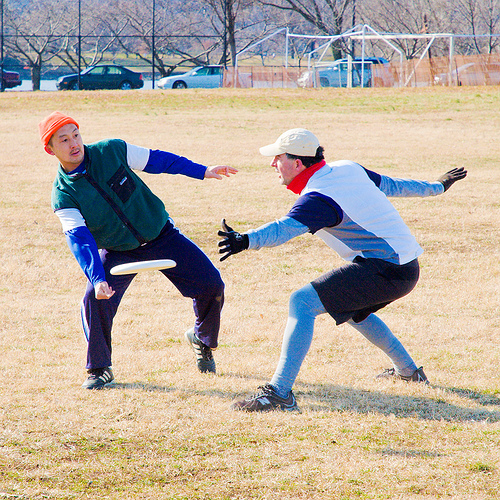

Image Path: 3168841415_c0705a327a.jpg | Similarity Score: 5.842251300811768


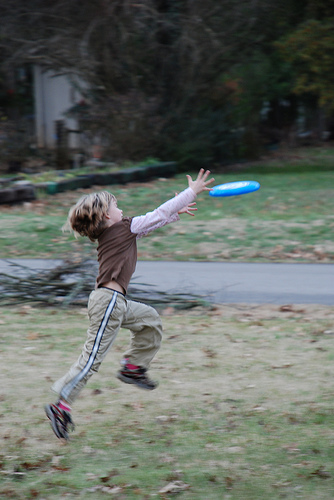

Image Path: 837893113_81854e94e3.jpg | Similarity Score: 5.841886520385742


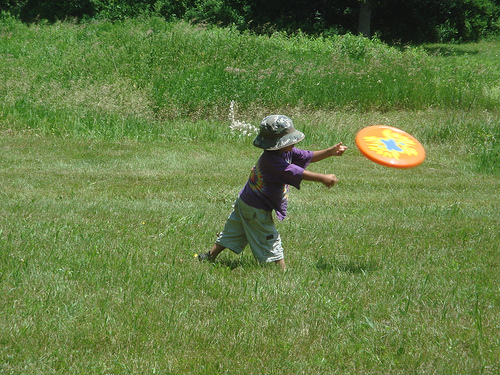

In [12]:
query_text = "children playing with frisbee in a park"
results = search(query_text)
print(results)

# Display results
if results:
    for path, score in results:
        print(f"Image Path: {path} | Similarity Score: {score}")
        display(Image.open(os.path.join(dataset_path, "Images", path)))
else:
    print("No results found.")